In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing, neighbors, svm
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
%matplotlib inline
plt.style.use('seaborn-white')

Here we are just dealing with Cu data

In [2]:
data = pd.ExcelFile('Data1/Cu.xlsx')
print(data.sheet_names)

['Sheet1', 'Sheet3', 'xS vs FeS domain']


In [3]:
df1 = data.parse('Sheet1')
df1.head(5)

,Reference,Run #,D(Cu),Dinv,LnFeDomains,LnDinv
0,NaN,IT10,0.43,2.325581,-0.063935,0.843970
1,3,IT11,0.32,3.125000,-0.171537,1.139434
2,Chabot 2008,IT14,0.33,3.030303,-0.297457,1.108663
3,"Fe-Ni-S, 1 atm",IT3,0.33,3.030303,-0.565593,1.108663
4,NaN,IT4,0.24,4.166667,-0.818951,1.427116


In [4]:
df2 = df1.drop(['Reference', 'Run #', 'D(Cu)'], axis=1)
df2.dropna()
pd.options.display.max_rows = 999
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 3 columns):
Dinv           72 non-null float64
LnFeDomains    72 non-null float64
LnDinv         72 non-null float64
dtypes: float64(3)
memory usage: 1.8 KB


,Dinv,LnFeDomains,LnDinv
0,2.325581,-0.063935,0.843970
1,3.125000,-0.171537,1.139434
2,3.030303,-0.297457,1.108663
3,3.030303,-0.565593,1.108663
4,4.166667,-0.818951,1.427116


In [5]:
df2['FeDomains'] = np.exp(df2['LnFeDomains'])
df2.head()

,Dinv,LnFeDomains,LnDinv,FeDomains
0,2.325581,-0.063935,0.843970,0.938066
1,3.125000,-0.171537,1.139434,0.842369
2,3.030303,-0.297457,1.108663,0.742704
3,3.030303,-0.565593,1.108663,0.568023
4,4.166667,-0.818951,1.427116,0.440894


**Assumption**: We have initially asssumed that all the non-metals have equal impact, and the concentration of Fe-domains is the only criteron on which the fractionation of elements depends.

Plotting Fe-Domains vs 1/D

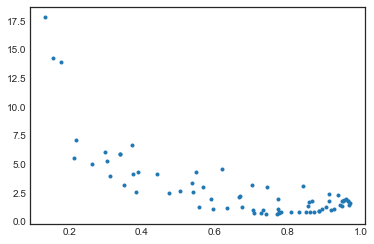

In [6]:
plt.plot(df2['FeDomains'],df2['Dinv'], marker='.', linestyle='none')
plt.show()

In [7]:
df2['Dinv'].min()

0.625

Dinv reaches its minimum value at aroud 7 and after that no point is below that, this curve looks more like a **hyperbola** than a linear , quadratic or logarithmic fit.

But if we **reject the Fe-C data** then even a linear model will give us a nice fit. Try this with qualitative variable introduction of different non-metals.

#### **(A)** Fitting a linear model

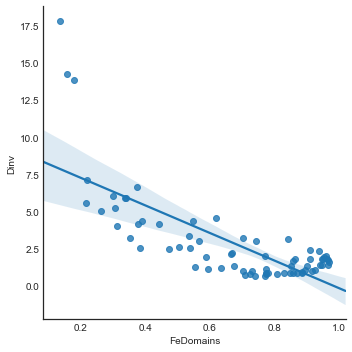

In [8]:
sns.lmplot(x='FeDomains', y='Dinv', data=df2)
plt.show()

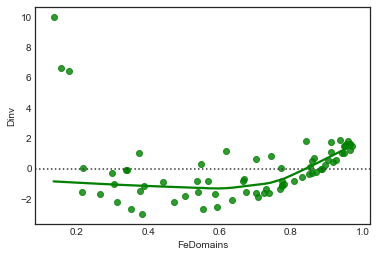

In [9]:
sns.residplot(x='FeDomains', y='Dinv', lowess=True, order = 1,data=df2, color='green')
plt.show()

**Residual plots are tools to identify non-linearity of data. Ideally, residual plots show no discernible pattern but presence of a pattern may show problem with some aspect of linear model.**

Here we can clearly see a pattern in the values of residuals and also the R^2 value of the fit is too low.
Trying log, minus x2, square-root x to remove any pattern from the residual plot.

In [10]:
est = smf.ols('Dinv ~ FeDomains', df2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Dinv   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     84.07
Date:                Sun, 08 Jul 2018   Prob (F-statistic):           1.30e-13
Time:                        23:15:40   Log-Likelihood:                -154.85
No. Observations:                  72   AIC:                             313.7
Df Residuals:                      70   BIC:                             318.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.1166      0.723     12.616      0.000       7.675      10.558
FeDomains     -9.2683      1.011     -9.169      0.000     -11.284      -7.252
==============================================================================
Omnibus:                       52.668   Durbin-Watson:                   0.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.974
Skew:                           2.215   Prob(JB):                     8.52e-50
Kurtosis:                      10.463   Cond. No.                         5.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The linear regression model assumes that there is a straight-line relationship between the predictors and the response. If the true relationship is far from linear, then virtually all of the conclusions that we draw from the fit are suspect. In addition, the prediction accuracy of the model can be significantly reduced.
The nonlinearity in the regression plot and the poor R-squared value(~.54) tells us that linear model is not suitable for this data.

Degree 2 might do better!

### (B) Squared model

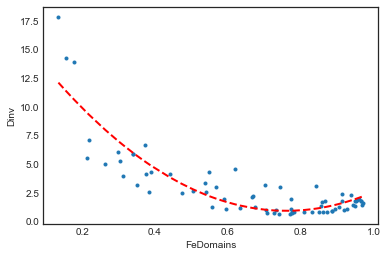

Function equation : 
        2
28.62 x - 43.5 x + 17.47


In [11]:
fit = np.polyfit(df2['FeDomains'],df2['Dinv'], 2)
fit_fn = np.poly1d(fit)

plt.plot(df2['FeDomains'],df2['Dinv'], '.', np.sort(df2['FeDomains']), fit_fn(np.sort(df2['FeDomains'])), '--r', linewidth=2)
plt.xlabel("FeDomains")
plt.ylabel("Dinv")
plt.show()
print('Function equation : \n',fit_fn)

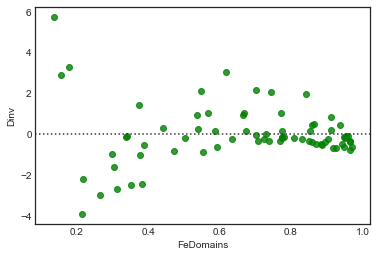

In [12]:
sns.residplot(x='FeDomains', y='Dinv', order = 2,data=df2, color='green')
plt.show()

The residual plot makes us clear the non-linearity of the data in the squared model above.

**IF WE COULD JUST IGNORE THE THREE POINTS** at the top then the rest of the data fits the linear model just fine. While, on changing the degree to 2 other than the 3 points on the top, rest of the model resists the degree 2 model.

However, this time we get a higher Rsquared value (~.78), than the linear model. But this is due to the fact that the earlier linear model was distorted too much by the outlier values of the Fe-Ni-C data.

In [13]:
est = smf.ols('Dinv ~ FeDomains + np.square(FeDomains)', df2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Dinv   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     125.9
Date:                Sun, 08 Jul 2018   Prob (F-statistic):           9.48e-24
Time:                        23:18:30   Log-Likelihood:                -127.94
No. Observations:                  72   AIC:                             261.9
Df Residuals:                      69   BIC:                             268.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               17.4690      1.077     16.220      0.000      15.320      19.618
FeDomains              -43.5000      3.970    -10.957      0.000     -51.420     -35.580
np.square(FeDomains)    28.6214      3.267      8.760      0.000      22.103      35.140
==============================================================================
Omnibus:                       18.583   Durbin-Watson:                   1.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.610
Skew:                           0.792   Prob(JB):                     9.22e-10
Kurtosis:                       6.371   Cond. No.                         40.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### (C) Trying Square-root of x

Now rather than fitting a square-root line to the data, we are fitting a straight line to the squared data.

Now, this is a bit unintuitive, the reason is that np.polyfit works only with integer values

In [14]:
df2.head()

,Dinv,LnFeDomains,LnDinv,FeDomains
0,2.325581,-0.063935,0.843970,0.938066
1,3.125000,-0.171537,1.139434,0.842369
2,3.030303,-0.297457,1.108663,0.742704
3,3.030303,-0.565593,1.108663,0.568023
4,4.166667,-0.818951,1.427116,0.440894


In [15]:
df2['sqrtFeDomains'] = np.sqrt(df2['FeDomains'])
df2.head()

,Dinv,LnFeDomains,LnDinv,FeDomains,sqrtFeDomains
0,2.325581,-0.063935,0.843970,0.938066,0.968538
1,3.125000,-0.171537,1.139434,0.842369,0.917807
2,3.030303,-0.297457,1.108663,0.742704,0.861803
3,3.030303,-0.565593,1.108663,0.568023,0.753673
4,4.166667,-0.818951,1.427116,0.440894,0.663998


In [ ]:
## ya! this doesn't work, just gives a stright line
## So, we need to plot a regressio w/o a library or just a st-line on the square-rooted data
## Taking the square root seems much more convinient than writing the code w/o any library !! 

# fit = np.polyfit(df2['FeDomains'],df2['Dinv'], 0.5)
# fit_fn = np.poly1d(fit)

# plt.plot(df2['FeDomains'],df2['Dinv'], '.', np.sort(df2['FeDomains']), fit_fn(np.sort(df2['FeDomains'])), '--r', linewidth=2)
# plt.xlabel("FeDomains")
# plt.ylabel("Dinv")
# plt.show()

In [16]:
est = smf.ols('Dinv ~ FeDomains + sqrtFeDomains', df2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Dinv   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     184.2
Date:                Sun, 08 Jul 2018   Prob (F-statistic):           2.14e-28
Time:                        23:20:14   Log-Likelihood:                -116.77
No. Observations:                  72   AIC:                             239.5
Df Residuals:                      69   BIC:                             246.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        40.4117      2.781     14.532      0.000      34.864      45.959
FeDomains        52.3154      5.440      9.617      0.000      41.463      63.168
sqrtFeDomains   -90.5812      7.953    -11.390      0.000    -106.447     -74.716
==============================================================================
Omnibus:                        7.058   Durbin-Watson:                   1.167
Prob(Omnibus):                  0.029   Jarque-Bera (JB):               12.746
Skew:                           0.083   Prob(JB):                      0.00171
Kurtosis:                       5.055   Cond. No.                         99.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

regr_coeff : [ 52.31543059 -90.58121186]
regr_intercept : 40.41165509917685
regr_score : 0.8422477831659844


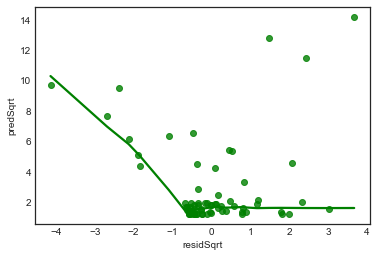

In [17]:
regr = skl_lm.LinearRegression()

# Linear fit
Xsqrt = df2[['FeDomains','sqrtFeDomains']].values
ysqrt = df2['Dinv']
regr.fit(Xsqrt, ysqrt)
print('regr_coeff :',regr.coef_)
print('regr_intercept :',regr.intercept_)
print('regr_score :',regr.score(Xsqrt,ysqrt))

df2['predSqrt'] = regr.predict(Xsqrt)
df2['residSqrt'] = df2.Dinv - df2.predSqrt

sns.regplot(df2['residSqrt'],df2['predSqrt'], lowess=True, color='green')

Now, the sqrt model is definately rejected with this much non-linearity in the data.

### (D) Trying log of x

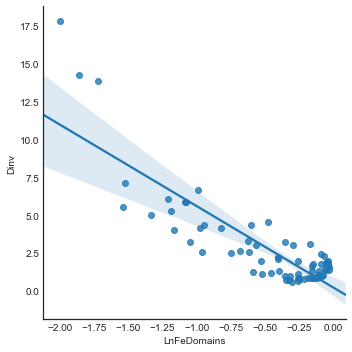

In [18]:
sns.lmplot(x='LnFeDomains', y='Dinv', data=df2)
plt.show()

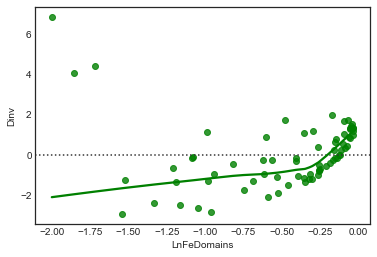

In [19]:
sns.residplot(x='LnFeDomains', y='Dinv', lowess=True, order = 1,data=df2, color='green')
plt.show()

Here the regression line of the residual plot looks better than the squared model(B). The residual curve for the linear model(A) might look better than this one at first glance but its has a different axis than this and actually that one is very similar to this one. But this might also be due to outliers. W/o the outliers the regression plot of residuals will be worse.

In [20]:
est = smf.ols('Dinv ~ LnFeDomains', df2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Dinv   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     181.3
Date:                Sun, 08 Jul 2018   Prob (F-statistic):           4.13e-21
Time:                        23:33:23   Log-Likelihood:                -137.24
No. Observations:                  72   AIC:                             278.5
Df Residuals:                      70   BIC:                             283.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2343      0.277      0.845      0.401      -0.319       0.787
LnFeDomains    -5.3741      0.399    -13.466      0.000      -6.170      -4.578
==============================================================================
Omnibus:                       26.178   Durbin-Watson:                   0.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.571
Skew:                           1.222   Prob(JB):                     1.41e-12
Kurtosis:                       6.495   Cond. No.                         2.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Taking the log of X**(Rsquared value = 0.72), not as good as squared x.

**Summary**: Now Ln(Fe-domains) somewhat removes the non-linearity of the data, which is seen in the square(Fe-domains) model.
But the R^2 of the squared model (0.78) is better than the log model(0.72). Rest of the possible linear-models are rulled out when considering complete data.

### (E) Checking for hyperbola

In [21]:
df2['FeDomainsInv'] = np.reciprocal(df2['FeDomains'])
df2.head()

,Dinv,LnFeDomains,LnDinv,FeDomains,sqrtFeDomains,predSqrt,residSqrt,FeDomainsInv
0,2.325581,-0.063935,0.843970,0.938066,0.968538,1.755631,0.569950,1.066023
1,3.125000,-0.171537,1.139434,0.842369,0.917807,1.344516,1.780484,1.187128
2,3.030303,-0.297457,1.108663,0.742704,0.861803,1.203396,1.826907,1.346431
3,3.030303,-0.565593,1.108663,0.568023,0.753673,1.859406,1.170897,1.760491
4,4.166667,-0.818951,1.427116,0.440894,0.663998,3.331429,0.835238,2.268120


popt:  [2.70669002]


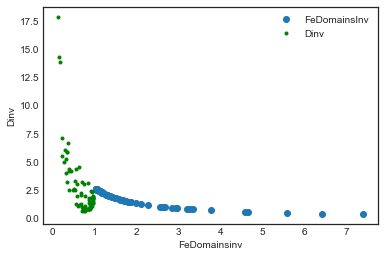

In [27]:
def hyperbola(t,a):
    return a/t

popt, pcov = curve_fit(hyperbola, df2['FeDomainsInv'], df2['Dinv'])
print('popt: ',popt)
plt.plot(df2['FeDomainsInv'], hyperbola(df2['FeDomainsInv'], *popt), 'o', )

plt.plot(df2['FeDomains'],df2['Dinv'], marker='.', linestyle='none',  color='green')

plt.xlabel('FeDomainsinv')
plt.ylabel('Dinv')
plt.legend()
plt.show()

Something is wrong with hyperbola, correct it.

#########################################################################
#########################################################################
#########################################################################

The data is resisting almost all the linear models. While we may get a much better fit on removing some of the data.

**SUMMARY:** 

**MODEL(A)**:  R^2 value is too low. But the model seems to have less non-linearity in the residual plots than the rest

**MODEL(B)**: R^2 value is good. But a clear non-linearity in data is visible in the residual plots.

**MODEL(c)**: Rulling out square-root of x for sure, non-linearity of the data is far too much.

**MODEL(D)**: R^2 value is decent not as hight as (B) but it also has much lesser non-linearity in data of the residual plots(comparable to (A).

**MODEL(E):** First do this one properly !

## Removed the 3 data points from the Fe-S-C system

In [54]:
data2 = pd.ExcelFile('ModifiedData/Cu_S-C_del.xlsx')
print(data.sheet_names)
df3 = data2.parse('Sheet1')
df3.head(5)

df4 = df3.drop(['Reference', 'Run #', 'D(Cu)'], axis=1)
df4.dropna()
pd.options.display.max_rows = 999
df4.info()

df4['FeDomains'] = np.exp(df4['LnFeDomains'])
df4['squaredFeDomains'] = np.square(df4['FeDomains'])

# df4= pd.DataFrame(dict(color=color))
# colors = {'1':'red', '2':'blue', '3':'green', '6':'black'}
# plt.plot(df4['FeDomains'],df4['Dinv'], marker='.', linestyle='none', c=df4['Fe-Ni-X'].apply(lambda x: colors[x]))

plt.show()
df4.head(69)

['Sheet1', 'Sheet3', 'xS vs FeS domain']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 4 columns):
Dinv           69 non-null float64
LnFeDomains    69 non-null float64
LnDinv         69 non-null float64
FeNiX          69 non-null int64
dtypes: float64(3), int64(1)
memory usage: 2.2 KB


,Dinv,LnFeDomains,LnDinv,FeNiX,FeDomains,squaredFeDomains
0,2.325581,-0.063935,0.843970,1,0.938066,0.879968
1,3.125000,-0.171537,1.139434,1,0.842369,0.709586
2,3.030303,-0.297457,1.108663,1,0.742704,0.551610
3,3.030303,-0.565593,1.108663,1,0.568023,0.322650
4,4.166667,-0.818951,1.427116,1,0.440894,0.194387
5,4.166667,-0.977994,1.427116,1,0.376065,0.141425
6,5.555556,-1.540667,1.714798,1,0.214238,0.045898
7,7.142857,-1.522616,1.966113,1,0.218141,0.047585
8,6.060606,-1.208104,1.801810,1,0.298763,0.089259
9,4.347826,-0.943130,1.469676,1,0.389407,0.151638


**(A1) Linear**

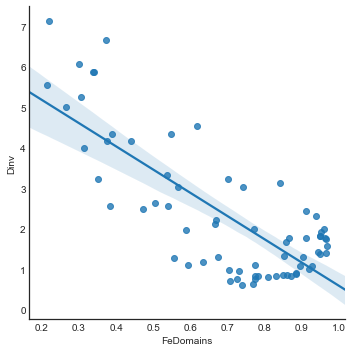

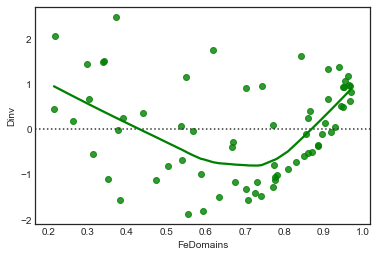

In [55]:
sns.lmplot(x='FeDomains', y='Dinv', data=df4)
plt.show()
sns.residplot(x='FeDomains', y='Dinv', lowess=True, order = 1,data=df4, color='green')
plt.show()

Non-linearity in the data is clearly visible here.

In [56]:
est = smf.ols('Dinv ~ FeDomains', df4).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Dinv   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     104.0
Date:                Mon, 09 Jul 2018   Prob (F-statistic):           2.90e-15
Time:                        00:52:33   Log-Likelihood:                -100.56
No. Observations:                  69   AIC:                             205.1
Df Residuals:                      67   BIC:                             209.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3292      0.410     15.435      0.000       5.511       7.148
FeDomains     -5.7314      0.562    -10.197      0.000      -6.853      -4.609
==============================================================================
Omnibus:                        4.830   Durbin-Watson:                   0.585
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                2.382
Skew:                           0.159   Prob(JB):                        0.304
Kurtosis:                       2.147   Cond. No.                         6.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**(A2) Squared**

In [59]:
# fit = np.polyfit(df4['FeDomains'],df4['Dinv'], 2)
# fit_fn = np.poly1d(fit)

# plt.plot(df4['FeDomains'],df4['Dinv'], '.', np.sort(df4['FeDomains']), fit_fn(np.sort(df4['FeDomains'])), '--r', linewidth=2)
# plt.xlabel("FeDomains")
# plt.ylabel("Dinv")
# plt.show()
# print('Function equation : \n',fit_fn)

# sns.residplot(x='squaredFeDomains', y='Dinv',lowess=True, order = 1,data=df4, color='green')
# plt.show()

## This thing fucks up, I don't know why, gives a st line in the residual plot.

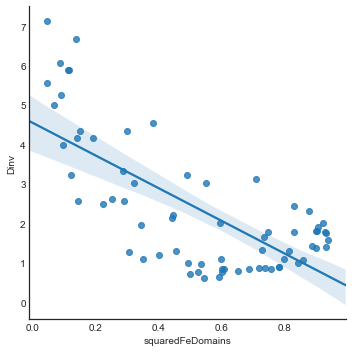

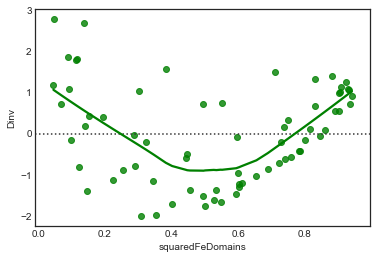

In [60]:
sns.lmplot(x='squaredFeDomains', y='Dinv', data=df4)
plt.show()
sns.residplot(x='squaredFeDomains', y='Dinv', lowess=True, order = 1,data=df4, color='green')
plt.show()

This one is again indicating non-linearity.

In [61]:
est = smf.ols('Dinv ~ FeDomains + squaredFeDomains', df4).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Dinv   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     91.81
Date:                Mon, 09 Jul 2018   Prob (F-statistic):           8.60e-20
Time:                        00:55:40   Log-Likelihood:                -86.980
No. Observations:                  69   AIC:                             180.0
Df Residuals:                      66   BIC:                             186.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           10.8787      0.875     12.433      0.000       9.132      12.626
FeDomains          -22.5945      3.025     -7.469      0.000     -28.635     -16.554
squaredFeDomains    13.4313      2.381      5.641      0.000       8.678      18.185
==============================================================================
Omnibus:                        8.899   Durbin-Watson:                   0.822
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.470
Skew:                           0.814   Prob(JB):                       0.0145
Kurtosis:                       3.545   Cond. No.                         50.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**(A3) LOG**

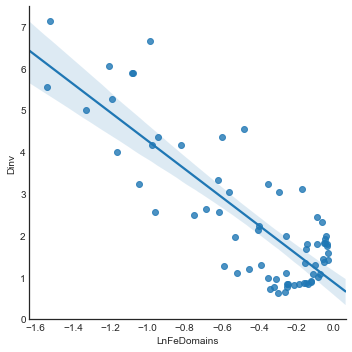

In [51]:
sns.lmplot(x='LnFeDomains', y='Dinv', data=df4)
plt.show()

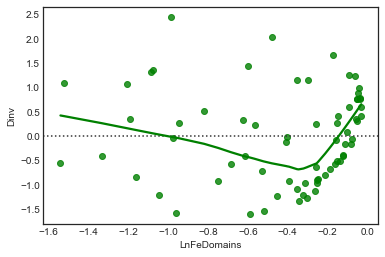

In [52]:
sns.residplot(x='LnFeDomains', y='Dinv', lowess=True, order = 1,data=df4, color='green')
plt.show()

In [63]:
est = smf.ols('Dinv ~ LnFeDomains', df4).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Dinv   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     143.6
Date:                Mon, 09 Jul 2018   Prob (F-statistic):           2.56e-18
Time:                        00:59:31   Log-Likelihood:                -93.369
No. Observations:                  69   AIC:                             190.7
Df Residuals:                      67   BIC:                             195.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.8732      0.168      5.186      0.000       0.537       1.209
LnFeDomains    -3.3978      0.284    -11.982      0.000      -3.964      -2.832
==============================================================================
Omnibus:                        2.763   Durbin-Watson:                   0.663
Prob(Omnibus):                  0.251   Jarque-Bera (JB):                2.252
Skew:                           0.311   Prob(JB):                        0.324
Kurtosis:                       2.371   Cond. No.                         3.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

I will check for hyperbola, as soon as posible.

## Replicating the research paper

Plotting Ln(Fe-domains) vs Ln(1/D)

In [ ]:
plt.plot(df2['LnFeDomains'],df2['LnDinv'], marker='.', linestyle='none')
plt.show()

In [ ]:
sns.lmplot(x='LnFeDomains', y='LnDinv', data=df2)
plt.show()

In [ ]:
fit = np.polyfit(df2['LnFeDomains'],df2['LnDinv'], 2)
fit_fn = np.poly1d(fit)

plt.plot(df2['LnFeDomains'],df2['LnDinv'], '.', np.sort(df2['LnFeDomains']), fit_fn(np.sort(df2['LnFeDomains'])), '--r', linewidth=2)
plt.xlabel("LnFeDomains")
plt.ylabel("LnDinv")
plt.show()

In [ ]:
sns.residplot(x='LnFeDomains', y='LnDinv', order = 2,data=df2, color='green')
plt.show()

Residual plots are tools to identify non-linearity of data. Ideally, residual plots show no discernible pattern but presence of a pattern may show problem with some aspect of linear model. 
Here we can clearly see that as the concentration of Fe domains increases the spread 
This data is suffering from **heteroscedasticity**

In [ ]:
# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.LinearRegression()

X = scale(df2['LnFeDomains'], with_mean=True, with_std=False).reshape(-1,1)
y = df2['LnDinv']

regr.fit(X,y)
print(X.shape)
print(y[:5])
print('Beta0:',regr.intercept_)
print('Beta1:',regr.coef_)

In [ ]:
est = smf.ols('LnDinv ~ LnFeDomains', df2).fit()
est.summary()

In [ ]:
# RSS with regression coefficients
((df2['LnDinv'] - (est.params[0] + est.params[1]*df2['LnFeDomains']))**2).sum()/1000

In [ ]:
regr = skl_lm.LinearRegression()

X = df2['LnFeDomains'].values.reshape(-1,1)
y = df2['LnDinv']

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

In [ ]:
LnDinv_pred = regr.predict(X)
r2_score(y, LnDinv_pred)

### MULTIPLE LINEAR REGRESSION

In [ ]:
est = smf.ols('LnDinv ~ LnFeDomains', df2).fit()
est.summary()